In [99]:
from typing import List, Dict, Any, Optional, Tuple, Iterable

In [100]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

載入價格

In [101]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 讀取NAS100資料
def load_nas100_data(file_path):
    """載入並預處理NAS100資料"""
    df = pd.read_csv(file_path)
    
    # 轉換時間格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # 使用BidClose作為主要價格
    df['Close'] = df['BidClose']
    df['High'] = df['BidHigh'] 
    df['Low'] = df['BidLow']
    df['Open'] = df['BidOpen']
    
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

# 資料重採樣
def resample_data(df, interval='1H'):
    """將15分鐘資料重採樣為指定間隔"""
    resampled = df.resample(interval).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min', 
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    return resampled

# 執行資料載入和重採樣
nas100_raw = load_nas100_data('equity_prices/US30.csv')

# # 僅保留 2015-11-01 之後
nas100_raw = nas100_raw.loc[nas100_raw.index >= '2018-11-01']
nas100_raw

# nas100_hourly = resample_data(nas100_raw, '1H')

# print(f"原始資料筆數: {len(nas100_raw)}")
# print(f"重採樣後筆數: {len(nas100_hourly)}")
# print(f"資料期間: {nas100_hourly.index[0]} 至 {nas100_hourly.index[-1]}")

,Open,High,Low,Close,Volume
Date,,,,,
2018-11-01 00:00:00,25154.50,25180.70,25147.20,25170.40,5575
2018-11-01 00:15:00,25170.40,25173.60,25147.00,25150.20,4608
2018-11-01 00:30:00,25150.20,25188.80,25148.30,25183.20,4734
2018-11-01 00:45:00,25183.20,25187.40,25173.30,25186.30,3737
2018-11-01 01:00:00,25186.30,25193.50,25167.40,25172.40,5909
...,...,...,...,...,...
2025-09-12 05:00:00,46102.36,46111.86,46097.36,46110.36,272
2025-09-12 05:15:00,46110.36,46110.86,46100.36,46105.86,274
2025-09-12 05:30:00,46105.86,46112.36,46091.36,46108.86,381


回測代碼

In [102]:
# =====================================================
# 回測系統：訊號進場 + 停損停利（支援動態槓桿調整 + 百分比停利）
# =====================================================
class BacktestEngine:
    """回測引擎：處理進場、停損、停利邏輯（支援動態槓桿調整 + 百分比停利）"""
    
    def __init__(self, stop_loss_pct=0.5, take_profit_bars=32, take_profit_pct=0.5,
                 initial_capital=100000, base_leverage=1.0):
        """
        Parameters:
        -----------
        stop_loss_pct : float
            停損百分比（預設 0.0025 = 0.25%）
        take_profit_bars : int
            停利K線數（預設 32）
        take_profit_pct : float
            停利百分比（預設 0.0025 = 0.25%）
        initial_capital : float
            初始資金（預設 100000）
        base_leverage : float
            基礎槓桿倍數（預設 1.0，如果沒有提供動態槓桿時使用）
        """
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_bars = take_profit_bars
        self.take_profit_pct = take_profit_pct
        self.initial_capital = initial_capital
        self.base_leverage = base_leverage
        self.trades = []
        self.price_df = None  # 保存價格數據供 Buy and Hold 計算使用
        
    def backtest(self, df: pd.DataFrame, signals: pd.Series, 
                 leverage_series: pd.Series = None, side_series: pd.Series = None) -> pd.DataFrame:
        """
        執行回測（支援動態槓桿調整 + 做空）
        
        Parameters:
        -----------
        df : pd.DataFrame
            價格資料（需包含 'Close', 'High', 'Low' 欄位）
        signals : pd.Series
            進場信號（True 表示進場點，需與 df 的 index 對齊）
        leverage_series : pd.Series, optional
            每筆交易的槓桿倍數（需與 df 的 index 對齊）
            如果為None，則所有交易使用base_leverage
        side_series : pd.Series, optional
            每筆交易的方向（1=做多, -1=做空），需與 df 的 index 對齊
            如果為None，則預設為 1 (做多)
            
        Returns:
        --------
        results : pd.DataFrame
            回測結果，包含每筆交易的詳細資訊
        """
        df = df.copy()
        signals = signals.copy()
        
        # 保存價格數據供後續使用（用於 buy and hold 計算）
        self.price_df = df.copy()
        
        # 確保 signals 與 df 的 index 對齊
        if not signals.index.equals(df.index):
            signals = signals.reindex(df.index, fill_value=False)
        
        # 處理槓桿倍數
        if leverage_series is None:
            leverage_series = pd.Series(self.base_leverage, index=df.index)
        else:
            leverage_series = leverage_series.copy()
            if not leverage_series.index.equals(df.index):
                leverage_series = leverage_series.reindex(df.index, fill_value=self.base_leverage)
                
        # 處理方向
        if side_series is None:
            side_series = pd.Series(1, index=df.index)
        else:
            side_series = side_series.copy()
            if not side_series.index.equals(df.index):
                side_series = side_series.reindex(df.index, fill_value=1)
        
        # 初始化狀態
        position = None  # None: 無持倉, dict: {entry_time, entry_price, side, units, leverage, capital_used}
        trades = []
        current_equity = self.initial_capital  # 當前總equity
        
        for i, (timestamp, row) in enumerate(df.iterrows()):
            current_close = row['Close']
            current_high = row['High']
            current_low = row['Low']
            has_signal = signals.loc[timestamp]
            leverage = leverage_series.loc[timestamp]
            
            # ============================================
            # 邏輯1: 檢查進場條件（確保同時只會進場一次）
            # ============================================
            if has_signal and position is None:
                # 取得方向
                entry_side = side_series.loc[timestamp]
                if pd.isna(entry_side): entry_side = 1
                
                # 計算可進場的單位數
                # 可用資金 = 當前總equity * 槓桿倍數
                available_capital = current_equity * leverage
                
                # 計算可買入的單位數（假設1單位 = 1價格）
                # 實際應用中可能需要根據合約規格調整
                units = (available_capital / current_close) * 1
                
                # 實際使用的資金（不考慮槓桿時的資金）
                capital_used = current_equity
                
                # 以收盤價進場
                position = {
                    'entry_time': timestamp,
                    'entry_price': current_close,
                    'entry_idx': i,
                    'side': entry_side,
                    'units': units,  # 進場單位數
                    'leverage': leverage,  # 使用的槓桿倍數
                    'capital_used': capital_used  # 使用的資金
                }
                continue
            
            # ============================================
            # 邏輯2: 如果有持倉，檢查停損停利
            # ============================================
            if position is not None:
                entry_price = position['entry_price']
                entry_idx = position['entry_idx']
                side = position['side']
                units = position['units']
                leverage_used = position['leverage']
                capital_used = position['capital_used']
                
                # 計算停損價格
                stop_loss_price = entry_price * (1 - self.stop_loss_pct * side)
                
                # 計算停利價格
                take_profit_price = entry_price * (1 + self.take_profit_pct * side)
                
                # 計算持倉K線數
                bars_held = i - entry_idx
                
                # 檢查停損
                hit_stop_loss = False
                exit_price = None
                exit_reason = None
                
                if side == 1:  # 做多
                    if current_low <= stop_loss_price:
                        hit_stop_loss = True
                        exit_price = stop_loss_price
                        exit_reason = 'Stop Loss'
                elif side == -1: # 做空
                    if current_high >= stop_loss_price:
                        hit_stop_loss = True
                        exit_price = stop_loss_price
                        exit_reason = 'Stop Loss'
                
                # 檢查百分比停利
                hit_take_profit_pct = False
                if not hit_stop_loss:
                    if side == 1:  # 做多
                        if current_high >= take_profit_price:
                            hit_take_profit_pct = True
                            exit_price = take_profit_price
                            exit_reason = 'Take Profit (0.25%)'
                    elif side == -1: # 做空
                        if current_low <= take_profit_price:
                            hit_take_profit_pct = True
                            exit_price = take_profit_price
                            exit_reason = 'Take Profit (0.25%)'
                
                # 檢查時間停利（32根K後以收盤價平倉）
                hit_take_profit_bars = False
                if bars_held >= self.take_profit_bars:
                    hit_take_profit_bars = True
                    # 如果還沒觸發百分比停利，才使用時間停利
                    if not hit_take_profit_pct and not hit_stop_loss:
                        exit_price = current_close
                        exit_reason = 'Take Profit (32 bars)'
                
                # 如果觸發停損或停利，執行平倉
                if hit_stop_loss or hit_take_profit_pct or hit_take_profit_bars:
                    # 計算實際盈虧金額
                    # 盈虧 = (出場價 - 進場價) * 單位數 * 方向
                    pnl = (exit_price - entry_price) * units * side
                    pnl = pnl - entry_price*0.0001
                    
                    # 計算報酬率（相對於使用的資金）
                    return_pct = (pnl / capital_used) * 100 if capital_used > 0 else 0
                    
                    # 更新當前總equity
                    current_equity = current_equity + pnl
                    
                    # 記錄交易
                    trade = {
                        'entry_time': position['entry_time'],
                        'exit_time': timestamp,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'side': side,
                        'units': units,
                        'leverage': leverage_used,
                        'capital_used': capital_used,
                        'pnl': pnl,  # 盈虧金額
                        'return_pct': return_pct,  # 報酬率
                        'bars_held': bars_held,
                        'exit_reason': exit_reason,
                        'stop_loss_price': stop_loss_price,
                        'take_profit_price': take_profit_price,
                        'equity_after': current_equity  # 平倉後總equity
                    }
                    trades.append(trade)
                    
                    # 重置持倉
                    position = None
        
        # 處理最後一筆未平倉的交易（如果有的話）
        if position is not None:
            last_timestamp = df.index[-1]
            last_close = df['Close'].iloc[-1]
            entry_price = position['entry_price']
            side = position['side']
            units = position['units']
            leverage_used = position['leverage']
            capital_used = position['capital_used']
            bars_held = len(df) - 1 - position['entry_idx']
            
            pnl = (last_close - entry_price) * units * side
            return_pct = (pnl / capital_used) * 100 if capital_used > 0 else 0
            current_equity = current_equity + pnl
            
            trade = {
                'entry_time': position['entry_time'],
                'exit_time': last_timestamp,
                'entry_price': entry_price,
                'exit_price': last_close,
                'side': side,
                'units': units,
                'leverage': leverage_used,
                'capital_used': capital_used,
                'pnl': pnl,
                'return_pct': return_pct,
                'bars_held': bars_held,
                'exit_reason': 'End of Data',
                'stop_loss_price': entry_price * (1 - self.stop_loss_pct * side),
                'take_profit_price': entry_price * (1 + self.take_profit_pct * side),
                'equity_after': current_equity
            }
            trades.append(trade)
        
        # 轉換為 DataFrame
        if trades:
            results = pd.DataFrame(trades)
            self.trades = results
            self.final_equity = current_equity
            return results
        else:
            print("⚠️ 沒有產生任何交易")
            self.final_equity = current_equity
            return pd.DataFrame()
    def get_performance_metrics(self) -> dict:
        """計算績效指標"""
        if len(self.trades) == 0:
            return {}
        
        df = self.trades
        
        total_trades = len(df)
        winning_trades = len(df[df['pnl'] > 0])
        losing_trades = len(df[df['pnl'] < 0])
        
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        total_pnl = df['pnl'].sum()
        total_return_pct = ((self.final_equity - self.initial_capital) / self.initial_capital) * 100
        avg_return = df['return_pct'].mean()
        
        avg_win = df[df['pnl'] > 0]['return_pct'].mean() if winning_trades > 0 else 0
        avg_loss = df[df['pnl'] < 0]['return_pct'].mean() if losing_trades > 0 else 0
        
        avg_win_amount = df[df['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
        avg_loss_amount = df[df['pnl'] < 0]['pnl'].mean() if losing_trades > 0 else 0
        
        profit_factor = abs(avg_win_amount * winning_trades / (avg_loss_amount * losing_trades)) if losing_trades > 0 and avg_loss_amount != 0 else np.inf
        
        # 統計停損停利次數
        stop_loss_count = len(df[df['exit_reason'] == 'Stop Loss'])
        take_profit_pct_count = len(df[df['exit_reason'] == 'Take Profit (0.25%)'])
        take_profit_bars_count = len(df[df['exit_reason'] == 'Take Profit (32 bars)'])
        
        # 統計32根K後的賺錢和虧錢出場
        take_profit_bars_trades = df[df['exit_reason'] == 'Take Profit (32 bars)']
        take_profit_bars_win = len(take_profit_bars_trades[take_profit_bars_trades['pnl'] > 0])
        take_profit_bars_loss = len(take_profit_bars_trades[take_profit_bars_trades['pnl'] <= 0])
        
        # 統計百分比停利的賺錢和虧錢出場
        take_profit_pct_trades = df[df['exit_reason'] == 'Take Profit (0.25%)']
        take_profit_pct_win = len(take_profit_pct_trades[take_profit_pct_trades['pnl'] > 0])
        take_profit_pct_loss = len(take_profit_pct_trades[take_profit_pct_trades['pnl'] <= 0])
        
        # 統計不同槓桿的交易
        if 'leverage' in df.columns:
            leverage_0_5 = len(df[df['leverage'] == 0.5])
            leverage_1_0 = len(df[df['leverage'] == 1.0])
            leverage_2_0 = len(df[df['leverage'] == 2.0])
        else:
            leverage_0_5 = leverage_1_0 = leverage_2_0 = 0
        
        metrics = {
            'Initial Capital': self.initial_capital,
            'Final Equity': self.final_equity,
            'Total PnL': total_pnl,
            'Total Return (%)': total_return_pct,
            'Total Trades': total_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate (%)': win_rate * 100,
            'Average Return (%)': avg_return,
            'Average Win (%)': avg_win,
            'Average Loss (%)': avg_loss,
            'Average Win Amount': avg_win_amount,
            'Average Loss Amount': avg_loss_amount,
            'Profit Factor': profit_factor,
            'Stop Loss Count': stop_loss_count,
            'Take Profit Pct Count': take_profit_pct_count,
            'Take Profit Pct Win Count': take_profit_pct_win,
            'Take Profit Pct Loss Count': take_profit_pct_loss,
            'Take Profit Bars Count': take_profit_bars_count,
            'Take Profit Bars Win Count': take_profit_bars_win,
            'Take Profit Bars Loss Count': take_profit_bars_loss,
            'Leverage 0.5x Count': leverage_0_5,
            'Leverage 1.0x Count': leverage_1_0,
            'Leverage 2.0x Count': leverage_2_0
        }
        
        return metrics
    
    def print_summary(self):
        """印出回測摘要"""
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return
        
        metrics = self.get_performance_metrics()
        
        print("=" * 60)
        print("📊 回測結果摘要（含動態槓桿調整 + 百分比停利）")
        print("=" * 60)
        print(f"初始資金: ${metrics['Initial Capital']:,.2f}")
        print(f"最終總equity: ${metrics['Final Equity']:,.2f}")
        print(f"總盈虧: ${metrics['Total PnL']:,.2f}")
        print(f"總報酬率: {metrics['Total Return (%)']:.2f}%")
        print(f"總交易次數: {metrics['Total Trades']:,}")
        print(f"獲利交易: {metrics['Winning Trades']:,}")
        print(f"虧損交易: {metrics['Losing Trades']:,}")
        print(f"勝率: {metrics['Win Rate (%)']:.2f}%")
        print(f"平均報酬率: {metrics['Average Return (%)']:.2f}%")
        print(f"平均獲利: {metrics['Average Win (%)']:.2f}% (${metrics['Average Win Amount']:,.2f})")
        print(f"平均虧損: {metrics['Average Loss (%)']:.2f}% (${metrics['Average Loss Amount']:,.2f})")
        print(f"獲利因子: {metrics['Profit Factor']:.2f}")
        print(f"停損次數: {metrics['Stop Loss Count']:,}")
        print(f"百分比停利次數 (0.25%): {metrics['Take Profit Pct Count']:,}")
        print(f"  0.25%停利賺錢出場: {metrics['Take Profit Pct Win Count']:,}")
        print(f"  0.25%停利虧錢出場: {metrics['Take Profit Pct Loss Count']:,}")
        print(f"時間停利次數 (32根K): {metrics['Take Profit Bars Count']:,}")
        print(f"  32根K後賺錢出場: {metrics['Take Profit Bars Win Count']:,}")
        print(f"  32根K後虧錢出場: {metrics['Take Profit Bars Loss Count']:,}")
        print(f"槓桿分布:")
        print(f"  0.5x槓桿: {metrics['Leverage 0.5x Count']:,}")
        print(f"  1.0x槓桿: {metrics['Leverage 1.0x Count']:,}")
        print(f"  2.0x槓桿: {metrics['Leverage 2.0x Count']:,}")
        print("=" * 60)
    
    def plot_equity_curve(self):
        """繪製權益曲線（含 Buy and Hold 比較 + 最大回撤標記）"""
        import matplotlib.pyplot as plt
        from datetime import datetime

        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return

        if not hasattr(self, 'price_df') or self.price_df is None:
            print("⚠️ 缺少價格數據，無法計算 Buy and Hold 績效")
            return

        df = self.trades.copy()
        price_df = self.price_df.copy()

        df['cumulative_equity'] = self.initial_capital + df['pnl'].cumsum()
        df['cumulative_return_pct'] = ((df['cumulative_equity'] - self.initial_capital) / self.initial_capital) * 100

        # 最大回撤計算
        df['running_max'] = df['cumulative_equity'].cummax()
        df['drawdown_pct'] = (df['cumulative_equity'] / df['running_max'] - 1.0) * 100
        max_dd_pct = df['drawdown_pct'].min()
        max_dd_idx = df['drawdown_pct'].idxmin()
        max_dd_end_time = df.loc[max_dd_idx, 'exit_time']
        max_dd_start_idx = df.loc[:max_dd_idx, 'cumulative_equity'].idxmax()
        max_dd_start_time = df.loc[max_dd_start_idx, 'exit_time']

        first_entry_time = df['entry_time'].iloc[0] if len(df) > 0 else price_df.index[0]
        last_time = price_df.index[-1]
        start_price = price_df.loc[price_df.index >= first_entry_time, 'Close'].iloc[0]
        end_price = price_df['Close'].iloc[-1]
        bh_return_pct = ((end_price - start_price) / start_price) * 100
        bh_final_equity = self.initial_capital * (1 + bh_return_pct / 100)

        # 計算年化收益率
        # 策略時間跨度
        strategy_start = pd.to_datetime(first_entry_time)
        strategy_end = pd.to_datetime(df['exit_time'].iloc[-1])
        strategy_years = (strategy_end - strategy_start).total_seconds() / (365.25 * 24 * 3600)
        
        # Buy and Hold 時間跨度
        bh_start = pd.to_datetime(first_entry_time)
        bh_end = pd.to_datetime(last_time)
        bh_years = (bh_end - bh_start).total_seconds() / (365.25 * 24 * 3600)
        
        # 策略年化收益率
        strategy_total_return = df['cumulative_return_pct'].iloc[-1] / 100
        if strategy_years > 0:
            strategy_annualized_return = ((1 + strategy_total_return) ** (1 / strategy_years) - 1) * 100
        else:
            strategy_annualized_return = 0
        
        # Buy and Hold 年化收益率
        bh_total_return = bh_return_pct / 100
        if bh_years > 0:
            bh_annualized_return = ((1 + bh_total_return) ** (1 / bh_years) - 1) * 100
        else:
            bh_annualized_return = 0

        strategy_period = price_df.loc[price_df.index >= first_entry_time].copy()
        strategy_period['bh_equity'] = self.initial_capital * (1 + (strategy_period['Close'] - start_price) / start_price)
        strategy_period['bh_return_pct'] = ((strategy_period['bh_equity'] - self.initial_capital) / self.initial_capital) * 100

        stop_loss_trades = df[df['exit_reason'] == 'Stop Loss']
        take_profit_pct_trades = df[df['exit_reason'] == 'Take Profit (0.25%)']
        take_profit_bars_win = df[(df['exit_reason'] == 'Take Profit (32 bars)') & (df['pnl'] > 0)]
        take_profit_bars_loss = df[(df['exit_reason'] == 'Take Profit (32 bars)') & (df['pnl'] <= 0)]
        end_of_data = df[df['exit_reason'] == 'End of Data']

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 14))

        # Equity 曲線
        ax1.plot(df['exit_time'], df['cumulative_equity'],
                 linewidth=2, color='blue', alpha=0.7, label='Strategy Equity', marker='o', markersize=3)
        ax1.plot(strategy_period.index, strategy_period['bh_equity'],
                 linewidth=2, color='orange', alpha=0.7, label='Buy and Hold Equity', linestyle='--')
        ax1.axhline(y=self.initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
        ax1.axvspan(max_dd_start_time, max_dd_end_time, color='red', alpha=0.1, label='Max Drawdown Window')
        ax1.annotate(f'MDD: {abs(max_dd_pct):.2f}%',
                     xy=(max_dd_end_time, df.loc[max_dd_idx, 'cumulative_equity']),
                     xytext=(0, -40), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='red'),
                     color='red', fontsize=10, fontweight='bold')
        ax1.set_title('Equity Curve Comparison', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Equity ($)', fontsize=12)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

        # 累積報酬率
        ax2.plot(df['exit_time'], df['cumulative_return_pct'],
                 linewidth=2, color='green', alpha=0.7, label='Strategy Return (%)', marker='o', markersize=3)
        ax2.plot(strategy_period.index, strategy_period['bh_return_pct'],
                 linewidth=2, color='orange', alpha=0.7, label='Buy and Hold Return (%)', linestyle='--')

        if len(stop_loss_trades) > 0:
            ax2.scatter(stop_loss_trades['exit_time'], stop_loss_trades['cumulative_return_pct'],
                        color='red', s=30, alpha=0.6,
                        label=f'Stop Loss ({len(stop_loss_trades)})', marker='x')
        if len(take_profit_pct_trades) > 0:
            ax2.scatter(take_profit_pct_trades['exit_time'], take_profit_pct_trades['cumulative_return_pct'],
                        color='lime', s=50, alpha=0.7,
                        label=f'0.25% Take Profit ({len(take_profit_pct_trades)})', marker='*')
        if len(take_profit_bars_win) > 0:
            ax2.scatter(take_profit_bars_win['exit_time'], take_profit_bars_win['cumulative_return_pct'],
                        color='green', s=50, alpha=0.7,
                        label=f'32 Bars Profit ({len(take_profit_bars_win)})', marker='^')
        if len(take_profit_bars_loss) > 0:
            ax2.scatter(take_profit_bars_loss['exit_time'], take_profit_bars_loss['cumulative_return_pct'],
                        color='orange', s=50, alpha=0.7,
                        label=f'32 Bars Loss ({len(take_profit_bars_loss)})', marker='v')
        if len(end_of_data) > 0:
            ax2.scatter(end_of_data['exit_time'], end_of_data['cumulative_return_pct'],
                        color='gray', s=30, alpha=0.5,
                        label=f'End of Data ({len(end_of_data)})', marker='s')

        ax2.set_title('Cumulative Return (%) Comparison', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Time', fontsize=12)
        ax2.set_ylabel('Cumulative Return (%)', fontsize=12)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # 文字摘要
        ax3.axis('off')
        strategy_final_return = df['cumulative_return_pct'].iloc[-1]
        strategy_final_equity = df['cumulative_equity'].iloc[-1]
        excess_return = strategy_final_return - bh_return_pct
        excess_annualized_return = strategy_annualized_return - bh_annualized_return
        comparison_text = f"""
            Performance Comparison Summary
            {'=' * 50}
            Strategy Performance:
            Final Equity: ${strategy_final_equity:,.2f}
            Total Return: {strategy_final_return:.2f}%
            Annualized Return: {strategy_annualized_return:.2f}%
            Period: {strategy_years:.2f} years
            Total Trades: {len(df):,}
            Win Rate: {len(df[df['pnl'] > 0]) / len(df) * 100:.2f}%

            Buy and Hold Performance:
            Final Equity: ${bh_final_equity:,.2f}
            Total Return: {bh_return_pct:.2f}%
            Annualized Return: {bh_annualized_return:.2f}%
            Period: {bh_years:.2f} years
            Entry Price: ${start_price:.2f}
            Exit Price: ${end_price:.2f}

            Comparison:
            Excess Return: {excess_return:.2f}%
            Excess Annualized Return: {excess_annualized_return:.2f}%
            {'Strategy Outperforms' if excess_return > 0 else 'Buy and Hold Outperforms'}

            Risk Metrics:
            Max Drawdown: {abs(max_dd_pct):.2f}%
            MDD Window: {max_dd_start_time} → {max_dd_end_time}
        """
        ax3.text(0.1, 0.5, comparison_text, fontsize=11,
                 family='monospace', verticalalignment='center',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Drawdown 圖
        ax4.fill_between(df['exit_time'], 0, df['drawdown_pct'],
                         color='crimson', alpha=0.3, step='mid')
        ax4.set_title('Drawdown (%)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Time', fontsize=12)
        ax4.set_ylabel('Drawdown (%)', fontsize=12)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax4.grid(True, alpha=0.3)
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()
        
    def get_monthly_statistics(self) -> pd.DataFrame:
        """計算每月統計（勝率、盈虧等）"""
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return pd.DataFrame()
        
        df = self.trades.copy()
        
        # 使用 exit_time 作為月份分組依據（因為盈虧在出場時實現）
        df['exit_time'] = pd.to_datetime(df['exit_time'])
        df['year_month'] = df['exit_time'].dt.to_period('M')
        
        # 按月分組統計
        monthly_stats = df.groupby('year_month').agg({
            'pnl': ['sum', 'count'],
            'return_pct': 'mean'
        }).reset_index()
        
        # 重新命名欄位
        monthly_stats.columns = ['year_month', 'total_pnl', 'trade_count', 'avg_return_pct']
        
        # 計算每月勝率
        monthly_win_rate = df.groupby('year_month').apply(
            lambda x: (x['pnl'] > 0).sum() / len(x) * 100 if len(x) > 0 else 0
        ).reset_index(name='win_rate_pct')
        
        # 合併統計
        monthly_stats = monthly_stats.merge(monthly_win_rate, on='year_month', how='left')
        
        # 計算每月賺錢/虧錢
        monthly_stats['is_profitable'] = monthly_stats['total_pnl'] > 0
        
        # 轉換 year_month 為字串格式（用於顯示）
        monthly_stats['month_str'] = monthly_stats['year_month'].astype(str)
        
        return monthly_stats
    
    def print_monthly_summary(self):
        """印出每月統計摘要"""
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return
        
        monthly_stats = self.get_monthly_statistics()
        
        if len(monthly_stats) == 0:
            print("⚠️ 無法計算每月統計")
            return
        
        # 計算總體統計
        total_months = len(monthly_stats)
        profitable_months = monthly_stats['is_profitable'].sum()
        losing_months = total_months - profitable_months
        
        print("=" * 60)
        print("📊 每月統計摘要")
        print("=" * 60)
        print(f"總月份數: {total_months}")
        print(f"賺錢月份: {profitable_months} ({profitable_months/total_months*100:.2f}%)")
        print(f"虧錢月份: {losing_months} ({losing_months/total_months*100:.2f}%)")
        print("=" * 60)
        print("\n每月詳細統計:")
        print("-" * 60)
        
        for _, row in monthly_stats.iterrows():
            month_str = row['month_str']
            total_pnl = row['total_pnl']
            trade_count = int(row['trade_count'])
            win_rate = row['win_rate_pct']
            status = "Profit" if row['is_profitable'] else "Loss"
            
            print(f"{month_str}: {status:6s} | PnL: ${total_pnl:>10,.2f} | "
                  f"Trades: {trade_count:>4d} | Win Rate: {win_rate:>6.2f}%")
        
        print("=" * 60)
    
    def plot_monthly_pnl(self):
        """繪製每月盈虧柱狀圖"""
        import matplotlib.pyplot as plt
        
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return
        
        monthly_stats = self.get_monthly_statistics()
        
        if len(monthly_stats) == 0:
            print("⚠️ 無法計算每月統計")
            return
        
        # 準備數據
        months = monthly_stats['month_str'].values
        pnl_values = monthly_stats['total_pnl'].values
        
        # 區分賺錢和虧錢的月份
        profitable_mask = monthly_stats['is_profitable'].values
        profitable_pnl = np.where(profitable_mask, pnl_values, 0)
        losing_pnl = np.where(~profitable_mask, pnl_values, 0)
        
        # 繪製圖表
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # ============================================
        # 上圖：每月盈虧柱狀圖（分顏色）
        # ============================================
        x_pos = np.arange(len(months))
        width = 0.6
        
        # 賺錢的月份用綠色，虧錢的月份用紅色
        bars1 = ax1.bar(x_pos, profitable_pnl, width, 
                       color='green', alpha=0.7, label='Profitable Months')
        bars2 = ax1.bar(x_pos, losing_pnl, width,
                       color='red', alpha=0.7, label='Losing Months')
        
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax1.set_xlabel('Month', fontsize=12)
        ax1.set_ylabel('PnL ($)', fontsize=12)
        ax1.set_title('Monthly Profit and Loss', fontsize=14, fontweight='bold')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(months, rotation=45, ha='right')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 在柱狀圖上標註數值
        for i, (prof, loss) in enumerate(zip(profitable_pnl, losing_pnl)):
            if prof != 0:
                ax1.text(i, prof, f'${prof:,.0f}', 
                        ha='center', va='bottom' if prof > 0 else 'top', 
                        fontsize=8, fontweight='bold')
            if loss != 0:
                ax1.text(i, loss, f'${loss:,.0f}', 
                        ha='center', va='top' if loss < 0 else 'bottom', 
                        fontsize=8, fontweight='bold')
        
        # ============================================
        # 下圖：每月勝率
        # ============================================
        win_rates = monthly_stats['win_rate_pct'].values
        colors = ['green' if pnl > 0 else 'red' for pnl in pnl_values]
        
        bars3 = ax2.bar(x_pos, win_rates, width, color=colors, alpha=0.7)
        ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% Win Rate')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Win Rate (%)', fontsize=12)
        ax2.set_title('Monthly Win Rate', fontsize=14, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(months, rotation=45, ha='right')
        ax2.set_ylim([0, 105])
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 在柱狀圖上標註數值
        for i, (wr, pnl) in enumerate(zip(win_rates, pnl_values)):
            ax2.text(i, wr, f'{wr:.1f}%', 
                    ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')
        
        # 添加總體統計文字
        total_months = len(monthly_stats)
        profitable_months = monthly_stats['is_profitable'].sum()
        losing_months = total_months - profitable_months
        
        stats_text = f"Total Months: {total_months} | "
        stats_text += f"Profitable: {profitable_months} ({profitable_months/total_months*100:.1f}%) | "
        stats_text += f"Losing: {losing_months} ({losing_months/total_months*100:.1f}%)"
        
        fig.suptitle(stats_text, fontsize=11, y=0.995)
        
        plt.tight_layout()
        plt.show()

策略代碼

In [103]:
import numpy as np
import pandas as pd
from typing import Optional

# =====================================================
# Granville L1 策略 - 趨勢反轉向上突破
# =====================================================
class GranvilleL1Strategy:
    """Granville L1: 移動平均線趨勢反轉向上突破策略"""
    
    def __init__(self, entry_param: int = 40, exit_param: int = 10):
        """
        Parameters:
        -----------
        entry_param : int
            移動平均線期數（預設 40）
        exit_param : int
            計算斜率的期數（預設 10）
        """
        self.entry_param = int(entry_param)
        self.exit_param = int(exit_param)
        self.signals = None
        
    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """計算策略指標"""
        df = df.copy()
        
        # 使用 AskClose 計算 SMA
        ask_close = df['AskClose'] if 'AskClose' in df.columns else df['Close']
        ask_open = df['AskOpen'] if 'AskOpen' in df.columns else df['Open']
        ask_high = df['AskHigh'] if 'AskHigh' in df.columns else df['High']
        
        # 計算移動平均線
        df['SMA40'] = ask_close.shift(1).rolling(window=self.entry_param).mean()
        
        # 計算斜率
        df['Slope'] = df['SMA40'].rolling(window=self.exit_param).apply(
            lambda x: np.polyfit(range(self.exit_param), x, 1)[0], raw=True
        )
        
        # 計算趨勢反轉條件
        recent_slope = df['Slope'].rolling(window=self.exit_param).mean()
        previous_slope = df['Slope'].shift(self.exit_param).rolling(window=self.exit_param).mean()
        df['Trend_Reversal'] = (recent_slope > 0) & (previous_slope < 0)
        
        # 設置突破信號價
        df['突破signal價'] = df['SMA40']
        
        # 生成信號：開盤 < SMA，最高 > SMA，且趨勢反轉
        df['signal'] = (
            (ask_open < df['突破signal價']) &
            (ask_high > df['突破signal價']) &
            df['Trend_Reversal']
        )
        df['signal'] = df['signal'].fillna(False).astype(bool)
        
        # 轉換為 side（做多方向）
        df['side'] = np.nan
        df.loc[df['signal'] == True, 'side'] = 1.0
        df['side'] = df['side'].ffill()
        
        self.signals = df
        
        # 統計資訊
        total_bars = len(df)
        signal_count = df['signal'].sum()
        signal_rate = signal_count / total_bars if total_bars > 0 else 0
        
        print("=" * 60)
        print("📊 Granville L1 策略統計")
        print("=" * 60)
        print(f"總 K 線數: {total_bars:,}")
        print(f"信號數量: {signal_count:,}")
        print(f"信號比例: {signal_rate:.4%}")
        print(f"策略參數: MA_period={self.entry_param}, Slope_period={self.exit_param}")
        print("=" * 60)
        
        return df


# =====================================================
# Granville L2 策略 - 上升趨勢回調買入
# =====================================================
class GranvilleL2Strategy:
    """Granville L2: 上升趨勢中回調至移動平均線買入策略"""
    
    def __init__(self, entry_param: int = 40, exit_param: int = 10):
        self.entry_param = int(entry_param)
        self.exit_param = int(exit_param)
        self.signals = None
        
    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        ask_close = df['AskClose'] if 'AskClose' in df.columns else df['Close']
        ask_low = df['AskLow'] if 'AskLow' in df.columns else df['Low']
        
        # 計算移動平均線
        df['SMA40'] = ask_close.shift(1).rolling(window=self.entry_param).mean()
        
        # 計算斜率
        df['Slope'] = df['SMA40'].rolling(window=self.exit_param).apply(
            lambda x: np.polyfit(range(self.exit_param), x, 1)[0], raw=True
        )
        
        # 檢查上升趨勢
        recent_slope = df['Slope'].rolling(window=self.exit_param).mean()
        df['Trend'] = (recent_slope > 0).shift(self.exit_param * 2).fillna(False)
        
        # 設置突破信號價
        df['突破signal價'] = df['SMA40']
        
        # 生成信號：最低 < SMA，收盤 > SMA，且在上升趨勢中
        df['signal'] = (
            (ask_low < df['突破signal價']) &
            (ask_close > df['突破signal價']) &
            (df['Trend'] == True)
        )
        df['signal'] = df['signal'].fillna(False).astype(bool)
        
        # 更新突破信號價為收盤價
        df['突破signal價'] = ask_close
        
        # 轉換為 side
        df['side'] = np.nan
        df.loc[df['signal'] == True, 'side'] = 1.0
        df['side'] = df['side'].ffill()
        
        self.signals = df
        
        # 統計資訊
        total_bars = len(df)
        signal_count = df['signal'].sum()
        signal_rate = signal_count / total_bars if total_bars > 0 else 0
        
        print("=" * 60)
        print("📊 Granville L2 策略統計")
        print("=" * 60)
        print(f"總 K 線數: {total_bars:,}")
        print(f"信號數量: {signal_count:,}")
        print(f"信號比例: {signal_rate:.4%}")
        print(f"策略參數: MA_period={self.entry_param}, Slope_period={self.exit_param}")
        print("=" * 60)
        
        return df


# =====================================================
# Granville L4 策略 - 上升趨勢觸碰MA買入
# =====================================================
class GranvilleL4Strategy:
    """Granville L4: 上升趨勢中觸碰移動平均線買入策略"""
    
    def __init__(self, entry_param: int = 40, exit_param: int = 10):
        self.entry_param = int(entry_param)
        self.exit_param = int(exit_param)
        self.signals = None
        
    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        ask_close = df['AskClose'] if 'AskClose' in df.columns else df['Close']
        ask_open = df['AskOpen'] if 'AskOpen' in df.columns else df['Open']
        ask_low = df['AskLow'] if 'AskLow' in df.columns else df['Low']
        
        # 計算移動平均線
        df['SMA40'] = ask_close.shift(1).rolling(window=self.entry_param).mean()
        
        # 計算斜率
        df['Slope'] = df['SMA40'].rolling(window=self.exit_param).apply(
            lambda x: np.polyfit(range(self.exit_param), x, 1)[0], raw=True
        )
        
        # 檢查上升趨勢
        recent_slope = df['Slope'].rolling(window=self.exit_param).mean()
        df['Trend'] = (recent_slope > 0).shift(self.exit_param).fillna(False)
        
        # 設置突破信號價
        df['突破signal價'] = df['SMA40']
        
        # 生成信號：最低 <= SMA，開盤 > SMA，收盤 >= SMA，且在上升趨勢中
        df['signal'] = (
            (ask_low <= df['SMA40']) &
            (ask_open > df['SMA40']) &
            (ask_close >= df['SMA40']) &
            (df['Trend'] == True)
        )
        df['signal'] = df['signal'].fillna(False).astype(bool)
        
        # 轉換為 side
        df['side'] = np.nan
        df.loc[df['signal'] == True, 'side'] = 1.0
        df['side'] = df['side'].ffill()
        
        self.signals = df
        
        # 統計資訊
        total_bars = len(df)
        signal_count = df['signal'].sum()
        signal_rate = signal_count / total_bars if total_bars > 0 else 0
        
        print("=" * 60)
        print("📊 Granville L4 策略統計")
        print("=" * 60)
        print(f"總 K 線數: {total_bars:,}")
        print(f"信號數量: {signal_count:,}")
        print(f"信號比例: {signal_rate:.4%}")
        print(f"策略參數: MA_period={self.entry_param}, Slope_period={self.exit_param}")
        print("=" * 60)
        
        return df


# =====================================================
# Granville S1 策略 - 趨勢反轉向下突破（做空）
# =====================================================
class GranvilleS1Strategy:
    """Granville S1: 移動平均線趨勢反轉向下突破做空策略"""
    
    def __init__(self, entry_param: int = 40, exit_param: int = 10):
        self.entry_param = int(entry_param)
        self.exit_param = int(exit_param)
        self.signals = None
        
    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        # 使用 BidClose 進行做空
        bid_close = df['BidClose'] if 'BidClose' in df.columns else df['Close']
        bid_open = df['BidOpen'] if 'BidOpen' in df.columns else df['Open']
        bid_low = df['BidLow'] if 'BidLow' in df.columns else df['Low']
        
        # 注意：這裡仍使用 AskClose 計算 SMA（因為原始代碼如此）
        ask_close = df['AskClose'] if 'AskClose' in df.columns else df['Close']
        
        # 計算移動平均線
        df['SMA40'] = ask_close.shift(1).rolling(window=self.entry_param).mean()
        
        # 計算斜率
        df['Slope'] = df['SMA40'].rolling(window=self.exit_param).apply(
            lambda x: np.polyfit(range(self.exit_param), x, 1)[0], raw=True
        )
        
        # 計算趨勢反轉條件（向下）
        recent_slope = df['Slope'].rolling(window=self.exit_param).mean()
        previous_slope = df['Slope'].shift(self.exit_param).rolling(window=self.exit_param).mean()
        df['Trend_Reversal'] = (recent_slope < 0) & (previous_slope > 0)
        
        # 設置突破信號價
        df['突破signal價'] = df['SMA40']
        
        # 生成信號：開盤 > SMA，最低 < SMA，且趨勢反轉
        df['signal'] = (
            (bid_open > df['突破signal價']) &
            (bid_low < df['突破signal價']) &
            df['Trend_Reversal']
        )
        df['signal'] = df['signal'].fillna(False).astype(bool)
        
        # 轉換為 side（做空方向）
        df['side'] = np.nan
        df.loc[df['signal'] == True, 'side'] = -1.0
        df['side'] = df['side'].ffill()
        
        self.signals = df
        
        # 統計資訊
        total_bars = len(df)
        signal_count = df['signal'].sum()
        signal_rate = signal_count / total_bars if total_bars > 0 else 0
        
        print("=" * 60)
        print("📊 Granville S1 策略統計（做空）")
        print("=" * 60)
        print(f"總 K 線數: {total_bars:,}")
        print(f"信號數量: {signal_count:,}")
        print(f"信號比例: {signal_rate:.4%}")
        print(f"策略參數: MA_period={self.entry_param}, Slope_period={self.exit_param}")
        print("=" * 60)
        
        return df


# =====================================================
# Granville S2 策略 - 下降趨勢反彈賣出（做空）
# =====================================================
class GranvilleS2Strategy:
    """Granville S2: 下降趨勢中反彈至移動平均線賣出做空策略"""
    
    def __init__(self, entry_param: int = 40, exit_param: int = 10):
        self.entry_param = int(entry_param)
        self.exit_param = int(exit_param)
        self.signals = None
        
    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        bid_close = df['BidClose'] if 'BidClose' in df.columns else df['Close']
        bid_high = df['BidHigh'] if 'BidHigh' in df.columns else df['High']
        
        # 使用 AskClose 計算 SMA
        ask_close = df['AskClose'] if 'AskClose' in df.columns else df['Close']
        
        # 計算移動平均線
        df['SMA40'] = ask_close.shift(1).rolling(window=self.entry_param).mean()
        
        # 計算斜率
        df['Slope'] = df['SMA40'].rolling(window=self.exit_param).apply(
            lambda x: np.polyfit(range(self.exit_param), x, 1)[0], raw=True
        )
        
        # 檢查下降趨勢
        recent_slope = df['Slope'].rolling(window=self.exit_param).mean()
        df['Trend'] = (recent_slope < 0).shift(self.exit_param * 2).fillna(False)
        
        # 設置突破信號價
        df['突破signal價'] = df['SMA40']
        
        # 生成信號：最高 > SMA，收盤 < SMA，且在下降趨勢中
        df['signal'] = (
            (bid_high > df['突破signal價']) &
            (bid_close < df['突破signal價']) &
            (df['Trend'] == True)
        )
        df['signal'] = df['signal'].fillna(False).astype(bool)
        
        # 更新突破信號價為收盤價
        df['突破signal價'] = bid_close
        
        # 轉換為 side（做空方向）
        df['side'] = np.nan
        df.loc[df['signal'] == True, 'side'] = -1.0
        df['side'] = df['side'].ffill()
        
        self.signals = df
        
        # 統計資訊
        total_bars = len(df)
        signal_count = df['signal'].sum()
        signal_rate = signal_count / total_bars if total_bars > 0 else 0
        
        print("=" * 60)
        print("📊 Granville S2 策略統計（做空）")
        print("=" * 60)
        print(f"總 K 線數: {total_bars:,}")
        print(f"信號數量: {signal_count:,}")
        print(f"信號比例: {signal_rate:.4%}")
        print(f"策略參數: MA_period={self.entry_param}, Slope_period={self.exit_param}")
        print("=" * 60)
        
        return df

## 依照策略訊號進出

📊 Granville L2 策略統計
總 K 線數: 160,749
信號數量: 8,044
信號比例: 5.0041%
策略參數: MA_period=32, Slope_period=4

前10筆交易:
           entry_time           exit_time  entry_price  exit_price  side  \
0 2018-11-01 13:00:00 2018-11-01 13:45:00      25224.2  25161.1395   1.0   
1 2018-11-01 14:00:00 2018-11-01 23:15:00      25244.1  25311.2000   1.0   
2 2018-11-01 23:45:00 2018-11-02 07:45:00      25339.7  25616.3000   1.0   
3 2018-11-02 12:15:00 2018-11-02 12:30:00      25607.6  25543.5810   1.0   
4 2018-11-02 12:45:00 2018-11-02 13:00:00      25602.4  25538.3940   1.0   
5 2018-11-05 06:15:00 2018-11-05 14:15:00      25243.9  25309.0000   1.0   
6 2018-11-06 03:30:00 2018-11-06 09:45:00      25492.4  25428.6690   1.0   
7 2018-11-06 19:30:00 2018-11-07 04:30:00      25532.1  25772.5000   1.0   
8 2018-11-07 06:30:00 2018-11-07 14:30:00      25725.6  25858.1000   1.0   
9 2018-11-07 15:00:00 2018-11-08 00:00:00      25832.4  26195.1000   1.0   

      units  leverage   capital_used          pnl  return

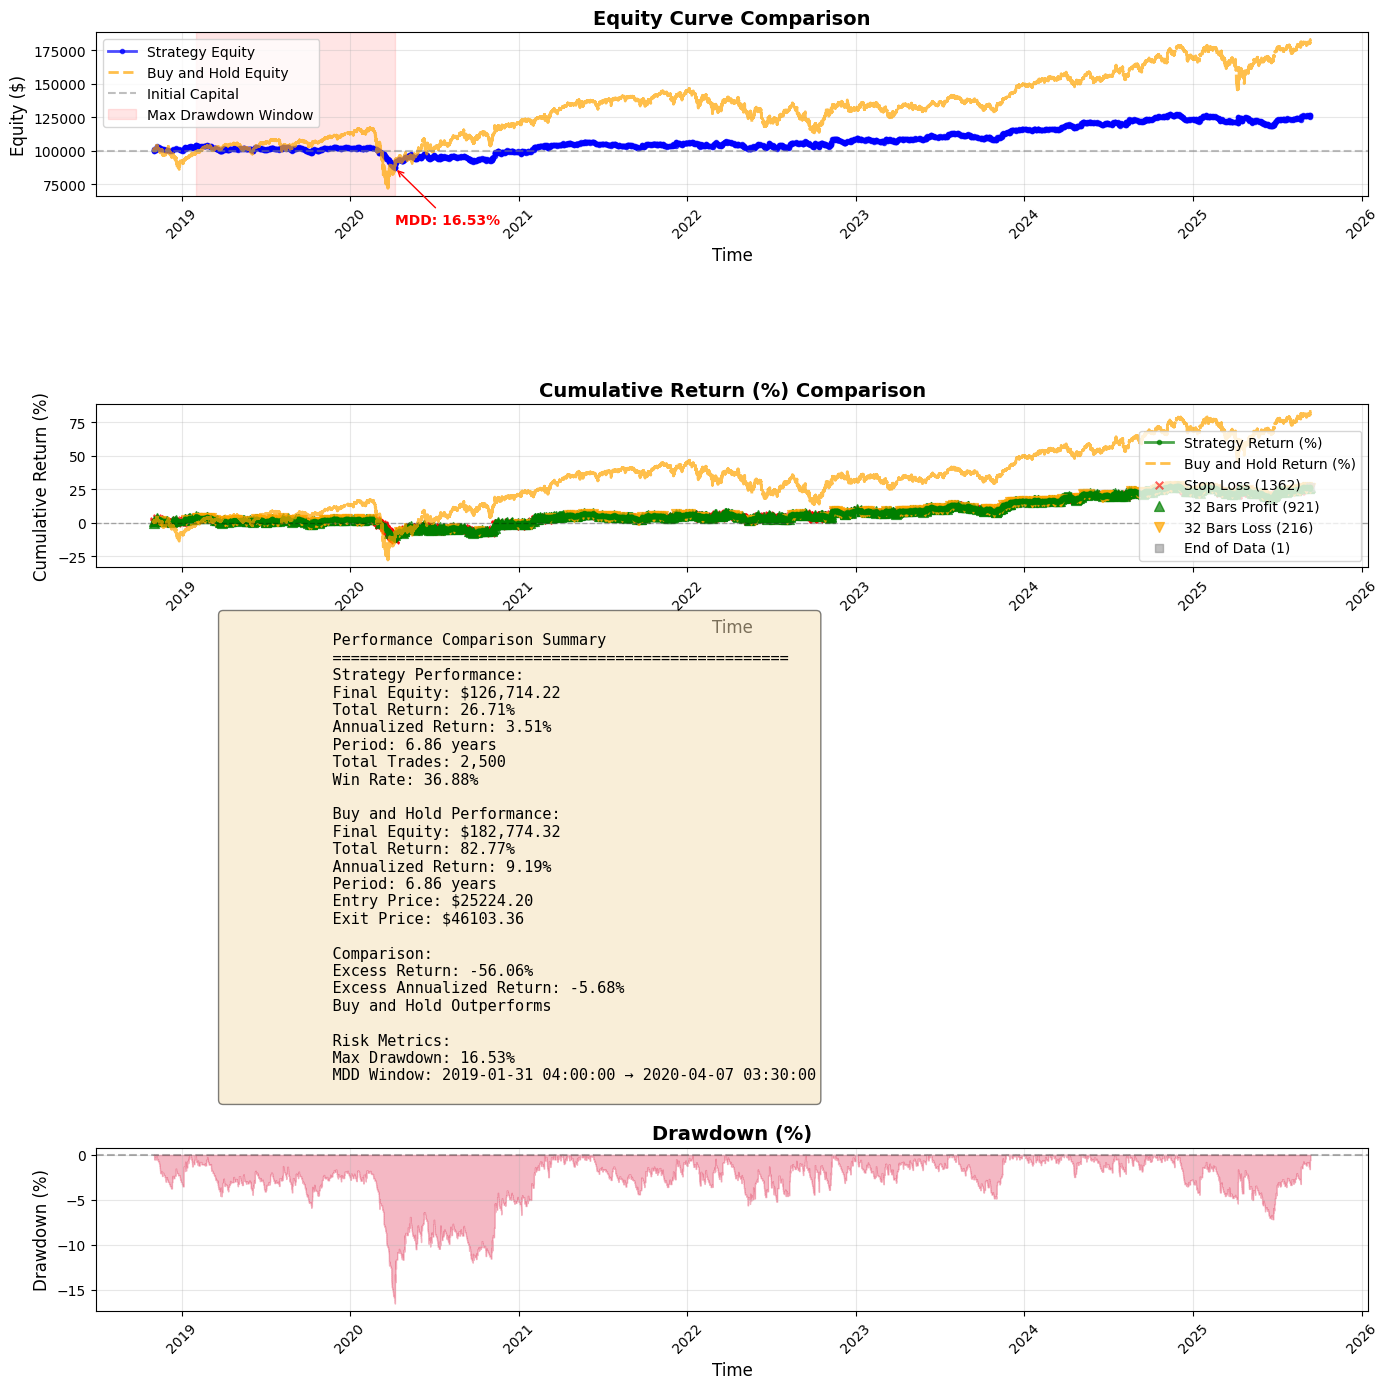


詳細績效指標:
Initial Capital: 100000
Final Equity: 126714.2195169321
Total PnL: 26714.219516932222
Total Return (%): 26.714219516932108
Total Trades: 2500
Winning Trades: 922
Losing Trades: 1578
Win Rate (%): 36.88
Average Return (%): 0.010309274522042264
Average Win (%): 0.4209864142043082
Average Loss (%): -0.22964276780181656
Average Win Amount: 448.0302062863792
Average Loss Amount: -244.84767470159022
Profit Factor: 1.069141613097224
Stop Loss Count: 1362
Take Profit Pct Count: 0
Take Profit Pct Win Count: 0
Take Profit Pct Loss Count: 0
Take Profit Bars Count: 1137
Take Profit Bars Win Count: 921
Take Profit Bars Loss Count: 216
Leverage 0.5x Count: 0
Leverage 1.0x Count: 2500
Leverage 2.0x Count: 0
📊 每月統計摘要
總月份數: 83
賺錢月份: 49 (59.04%)
虧錢月份: 34 (40.96%)

每月詳細統計:
------------------------------------------------------------
2018-11: Profit | PnL: $    635.89 | Trades:   32 | Win Rate:  34.38%
2018-12: Loss   | PnL: $   -262.33 | Trades:   15 | Win Rate:  26.67%
2019-01: Profit | PnL: $ 

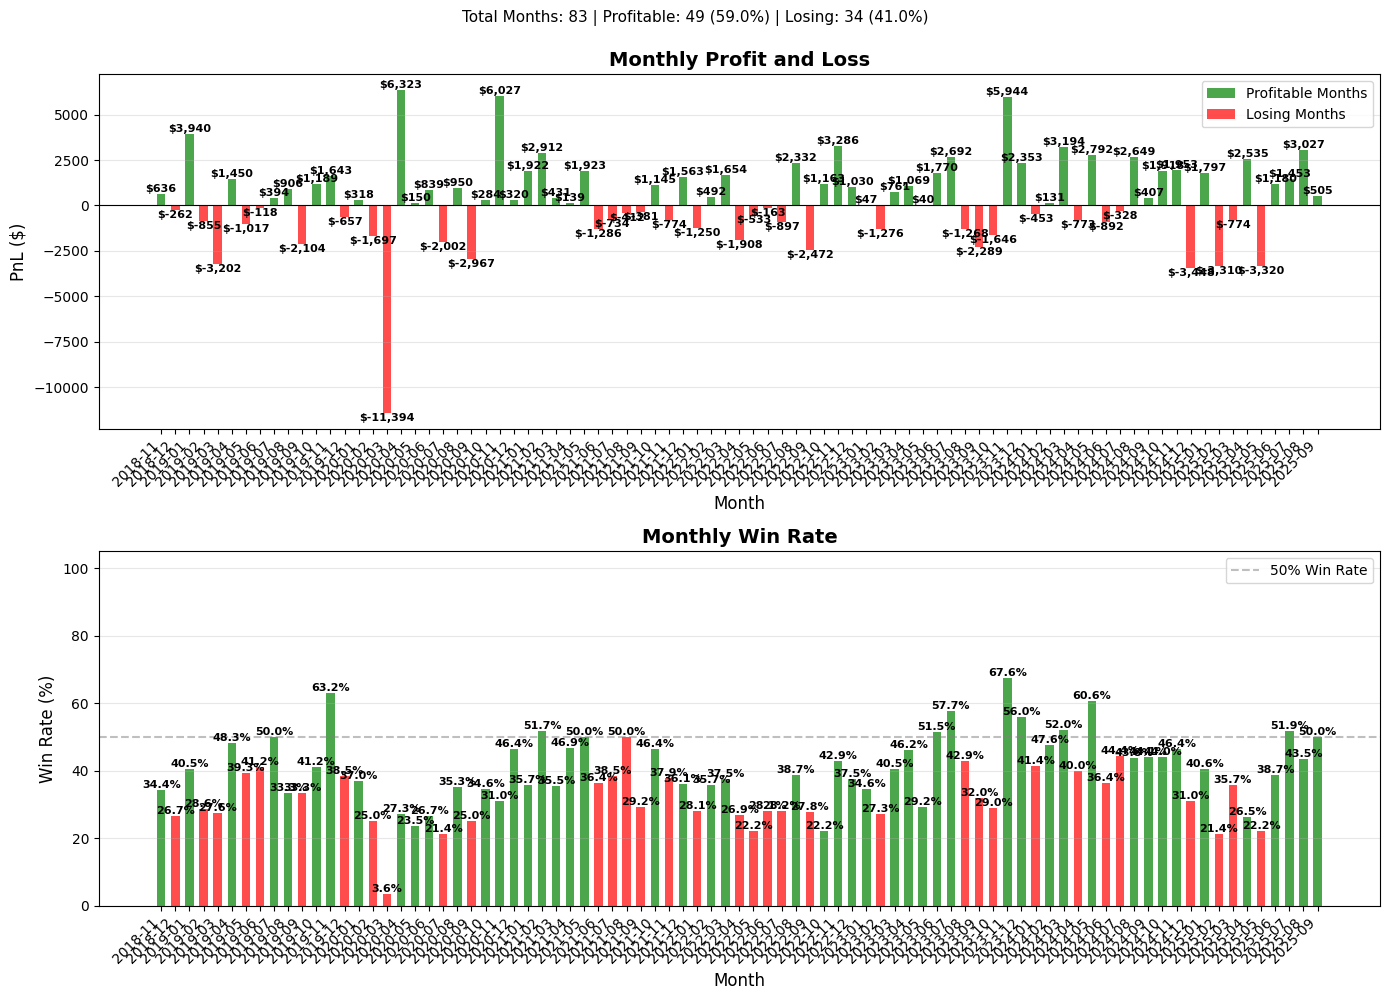

In [104]:
# 使用範例
# 假設你已經有 nas100_raw 資料和 L1Strategy 策略

# 1. 初始化策略並計算信號
# 多方策略
# strategy_l1 = GranvilleL1Strategy(entry_param=16, exit_param=4)
# df_with_signals = strategy_l1.calculate_indicators(nas100_raw)

strategy_l2 = GranvilleL2Strategy(entry_param=32, exit_param=4)
df_with_signals = strategy_l2.calculate_indicators(nas100_raw)

# strategy_l4 = GranvilleL4Strategy(entry_param=32, exit_param=4)
# df_with_signals = strategy_l4.calculate_indicators(nas100_raw)

# # 空方策略/
# strategy_s1 = GranvilleS1Strategy(entry_param=32, exit_param=4)
# df_with_signals = strategy_s1.calculate_indicators(nas100_raw)

# strategy_s2 = GranvilleS2Strategy(entry_param=32, exit_param=4)
# df_with_signals = strategy_s2.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（0.25%停損，32根K停利）
backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_pct=0.0025, take_profit_bars=32)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal'],
    side_series=df_with_signals['side']  # Pass side
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.head(10))

# 5. 查看績效摘要
backtest.print_summary()

# 6. 繪製權益曲線
backtest.plot_equity_curve()

# 7. 查看詳細績效指標
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
# 8. 查看每月統計摘要
backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()

In [105]:
# 使用範例
# 假設你已經有 nas100_raw 資料和 L1Strategy 策略

# 1. 初始化策略並計算信號
strategy = MaCrossUpStrategy(entry_param=480)
df_with_signals = strategy.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（0.25%停損，32根K停利）
backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_pct=0.0025, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_pct=0.0025, take_profit_bars=32)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal']
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.head(10))

# 5. 查看績效摘要
backtest.print_summary()

# 6. 繪製權益曲線
backtest.plot_equity_curve()

# 7. 查看詳細績效指標
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
# 8. 查看每月統計摘要
backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()

NameError: name 'MaCrossUpStrategy' is not defined

In [ ]:
# results.tail(50)

## 策略訊號 + ML篩選進場

只進預測1

In [ ]:
class MCrossUpLeverageStrategy:
    """MCrossUp 策略 + ML 預測篩選 + 槓桿調整 (基於價格向上穿越 MA)"""

    def __init__(
        self,
        entry_param: int = 20,           # MA 期數
        rolling_window: int = 20,        # 為了相容性保留參數名，實際對應 entry_param
        ml_pred_file: str = 'Pred_xgb.csv',
        allowed_predicted_labels: Optional[Iterable[int]] = None,
        leverage_map: Optional[Dict[int, float]] = None,
    ):
        self.entry_param = int(entry_param)
        # 若使用者傳入 rolling_window (舊參數)，可選擇忽略或覆寫 entry_param
        # 這裡暫時以 entry_param 為主
        self.ml_pred_file = ml_pred_file
        self.signals = None

        # 允許的 predicted_label；None 代表不過濾
        self.allowed_predicted_labels = (
            set(allowed_predicted_labels) if allowed_predicted_labels is not None else None
        )

        # 槓桿映射預設
        self.leverage_map = leverage_map or {-1: 0.5, 0: 1.0, 1: 2.0}

        self.ml_predictions = None
        self.ml_predicted_labels = None
        self.ml_start_time = None

        self._load_ml_predictions()

    def _load_ml_predictions(self):
        """載入 ML 預測檔（須含 entry_time 或 Date，以及 predicted_label 欄位）"""
        try:
            ml_df = pd.read_csv(self.ml_pred_file)

            # 優先使用 entry_time 作為日期索引
            if 'entry_time' in ml_df.columns:
                date_col = 'entry_time'
            elif 'Date' in ml_df.columns:
                date_col = 'Date'
            else:
                date_col = ml_df.columns[0]

            ml_df[date_col] = pd.to_datetime(ml_df[date_col])
            ml_df.set_index(date_col, inplace=True)
            ml_df.sort_index(inplace=True)

            if 'predicted_label' not in ml_df.columns:
                raise ValueError(f"{self.ml_pred_file} 缺少 predicted_label 欄位")

            self.ml_predicted_labels = ml_df['predicted_label']
            self.ml_predictions = self.ml_predicted_labels.map(self.leverage_map).fillna(1.0)
            self.ml_start_time = self.ml_predictions.index[0]

            print(f"✅ 載入 {self.ml_pred_file}：{len(self.ml_predictions):,} 筆")
            print(f"   時間範圍：{self.ml_predictions.index[0]} ~ {self.ml_predictions.index[-1]}")
            print("   predicted_label 分布：")
            for label, count in self.ml_predicted_labels.value_counts().sort_index().items():
                print(f"     {label}: {count:,}")
        except Exception as e:
            print(f"⚠️ 載入 ML 預測失敗：{e}")
            self.ml_predictions = pd.Series(dtype=float)
            self.ml_predicted_labels = pd.Series(dtype=float)
            self.ml_start_time = None

    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """計算策略指標：High 穿越 MA"""
        df = df.copy()
        
        # 檢查欄位
        ask_close = df['AskClose'] if 'AskClose' in df.columns else df['Close']
        ask_open = df['AskOpen'] if 'AskOpen' in df.columns else df['Open']
        ask_high = df['AskHigh'] if 'AskHigh' in df.columns else df['High']

        # 1. 計算移動平均線 (MA)
        # 注意：原邏輯為 shift(1).rolling，代表使用「前一根收盤價」開始計算過去 N 根
        df['MA'] = ask_close.shift(1).rolling(window=self.entry_param).mean()
        
        # 2. 計算價格相對於均線的位置 (僅供參考)
        df['MA%'] = df['MA'] / ask_close

        # 3. 生成穿越信號
        prev_close = ask_close.shift(1)
        
        df['signal'] = (
            (prev_close < df['MA']) &  # 前一根收盤在 MA 下
            (ask_high > df['MA']) &    # 當前最高價穿越 MA
            (ask_open < df['MA'])      # 當前開盤價在 MA 下
        )
        
        # 前 entry_param 根無信號
        df.loc[df.index[:self.entry_param], 'signal'] = False

        # ---------------------------
        # ML 與 槓桿邏輯
        # ---------------------------
        df['leverage'] = 1.0
        df['predicted_label'] = np.nan

        if self.ml_predictions is not None and len(self.ml_predictions) > 0:
            # 使用 reindex 對齊 ML 預測
            aligned_labels = self.ml_predicted_labels.reindex(df.index, method='ffill')
            aligned_leverage = self.ml_predictions.reindex(df.index, method='ffill').fillna(1.0)

            df['predicted_label'] = aligned_labels
            df['leverage'] = aligned_leverage

            # 統計
            if self.ml_start_time is not None:
                analysis_mask = df.index >= self.ml_start_time
                signal_labels = df.loc[df['signal'] & analysis_mask, 'predicted_label'].dropna()
                matched = len(signal_labels)
                total_signals = int(df.loc[analysis_mask, 'signal'].sum())
                
                print(f"✅ MCrossUp 信號 {total_signals:,} 筆 (在 ML 範圍內)，成功匹配 {matched:,} 筆 ML 預測")
                if matched > 0:
                    for label, count in signal_labels.value_counts().sort_index().items():
                        lev = self.leverage_map.get(label, 1.0)
                        print(f"   predicted_label={label}: {count:,} (leverage={lev}x)")
        else:
            print("⚠️ 無 ML 槓桿資料，全部使用 1.0x")

        if self.allowed_predicted_labels is not None:
            # 過濾信號
            allowed_mask = df['predicted_label'].isin(self.allowed_predicted_labels).fillna(False)
            
            if self.ml_start_time is not None:
                check_mask = (df.index >= self.ml_start_time) & df['signal']
                blocked = int(check_mask.sum() - (check_mask & allowed_mask).sum())
                print(f"🔍 ML 過濾：排除 {blocked:,} 筆不在 {sorted(self.allowed_predicted_labels)} 的信號")

            df['signal'] = df['signal'] & allowed_mask
            df.loc[~allowed_mask, 'leverage'] = 1.0

        df['side'] = np.nan
        df.loc[df['signal'], 'side'] = 1.0
        df['side'] = df['side'].ffill()

        self.signals = df

        signal_df = df[df['signal']]
        leverage_counts = signal_df['leverage'].value_counts().sort_index()

        print("=" * 60)
        print("📊 MCrossUp + ML 策略統計")
        print("=" * 60)
        print(f"總 K 線數: {len(df):,}")
        print(f"MCrossUp 信號數: {len(signal_df):,}")
        for lev, count in leverage_counts.items():
            print(f"  槓桿 {lev}x: {count:,} 筆")
        print("=" * 60)

        return df

    def get_signal_events(self) -> pd.DatetimeIndex:
        if self.signals is None:
            print("⚠️ 請先執行 calculate_indicators()")
            return None
        return self.signals.index[self.signals['signal']]

    def get_signal_stats(self) -> dict:
        if self.signals is None:
            return {}
        sig = self.signals[self.signals['signal']]
        total = len(sig)
        counts = sig['leverage'].value_counts().to_dict()
        return {
            'total_signals': total,
            'signal_rate': total / len(self.signals),
            'leverage_counts': counts,
            'avg_MA': self.signals['MA'].mean(),
        }

    def get_signal_stats(self) -> dict:
        if self.signals is None:
            return {}
        sig = self.signals[self.signals['signal']]
        total = len(sig)
        counts = sig['leverage'].value_counts().to_dict()
        return {
            'total_signals': total,
            'signal_rate': total / len(self.signals),
            'leverage_counts': counts,
            'avg_HL115': self.signals['HL115'].mean(),
            'avg_price_to_signal': (self.signals['Close'] / self.signals['突破signal價']).mean(),
        }

    def get_signal_stats(self) -> dict:
        if self.signals is None:
            return {}
        sig = self.signals[self.signals['signal']]
        total = len(sig)
        counts = sig['leverage'].value_counts().to_dict()
        return {
            'total_signals': total,
            'signal_rate': total / len(self.signals),
            'leverage_counts': counts,
            'avg_HL115': self.signals['HL115'].mean(),
            'avg_price_to_signal': (self.signals['Close'] / self.signals['突破signal價']).mean(),
        }

    def get_signal_stats(self) -> dict:
        if self.signals is None:
            return {}
        sig = self.signals[self.signals['signal']]
        total = len(sig)
        counts = sig['leverage'].value_counts().to_dict()
        return {
            'total_signals': total,
            'signal_rate': total / len(self.signals),
            'leverage_counts': counts,
            'avg_HL115': self.signals['HL115'].mean(),
            'avg_price_to_signal': (self.signals['Close'] / self.signals['突破signal價']).mean(),
        }

✅ 載入 C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaMaCrossUp\pred_results\pred_xgboost_2020_2025.csv：1,124 筆
   時間範圍：2020-01-29 01:30:00 ~ 2025-08-06 15:00:00
   predicted_label 分布：
     -1: 467
     0: 35
     1: 622
✅ MCrossUp 信號 2,258 筆 (在 ML 範圍內)，成功匹配 2,258 筆 ML 預測
   predicted_label=-1.0: 1,229 (leverage=1x)
   predicted_label=0.0: 77 (leverage=2x)
   predicted_label=1.0: 952 (leverage=4x)
🔍 ML 過濾：排除 1,229 筆不在 [0, 1] 的信號
📊 MCrossUp + ML 策略統計
總 K 線數: 137,458
MCrossUp 信號數: 1,029
  槓桿 2.0x: 77 筆
  槓桿 4.0x: 952 筆

前10筆交易:
             entry_time           exit_time  entry_price   exit_price  side  \
496 2025-07-14 13:45:00 2025-07-14 22:45:00      22757.8  22850.00000     1   
497 2025-07-16 06:45:00 2025-07-16 14:45:00      22821.8  22840.30000     1   
498 2025-07-16 15:00:00 2025-07-16 15:15:00      22891.9  22834.67025     1   
499 2025-07-16 15:45:00 2025-07-17 00:45:00      22840.6  22904.20000     1   
500 2025-07-22 14:00:00 2025-07-22 23:00:00      23046.3  23093.5000

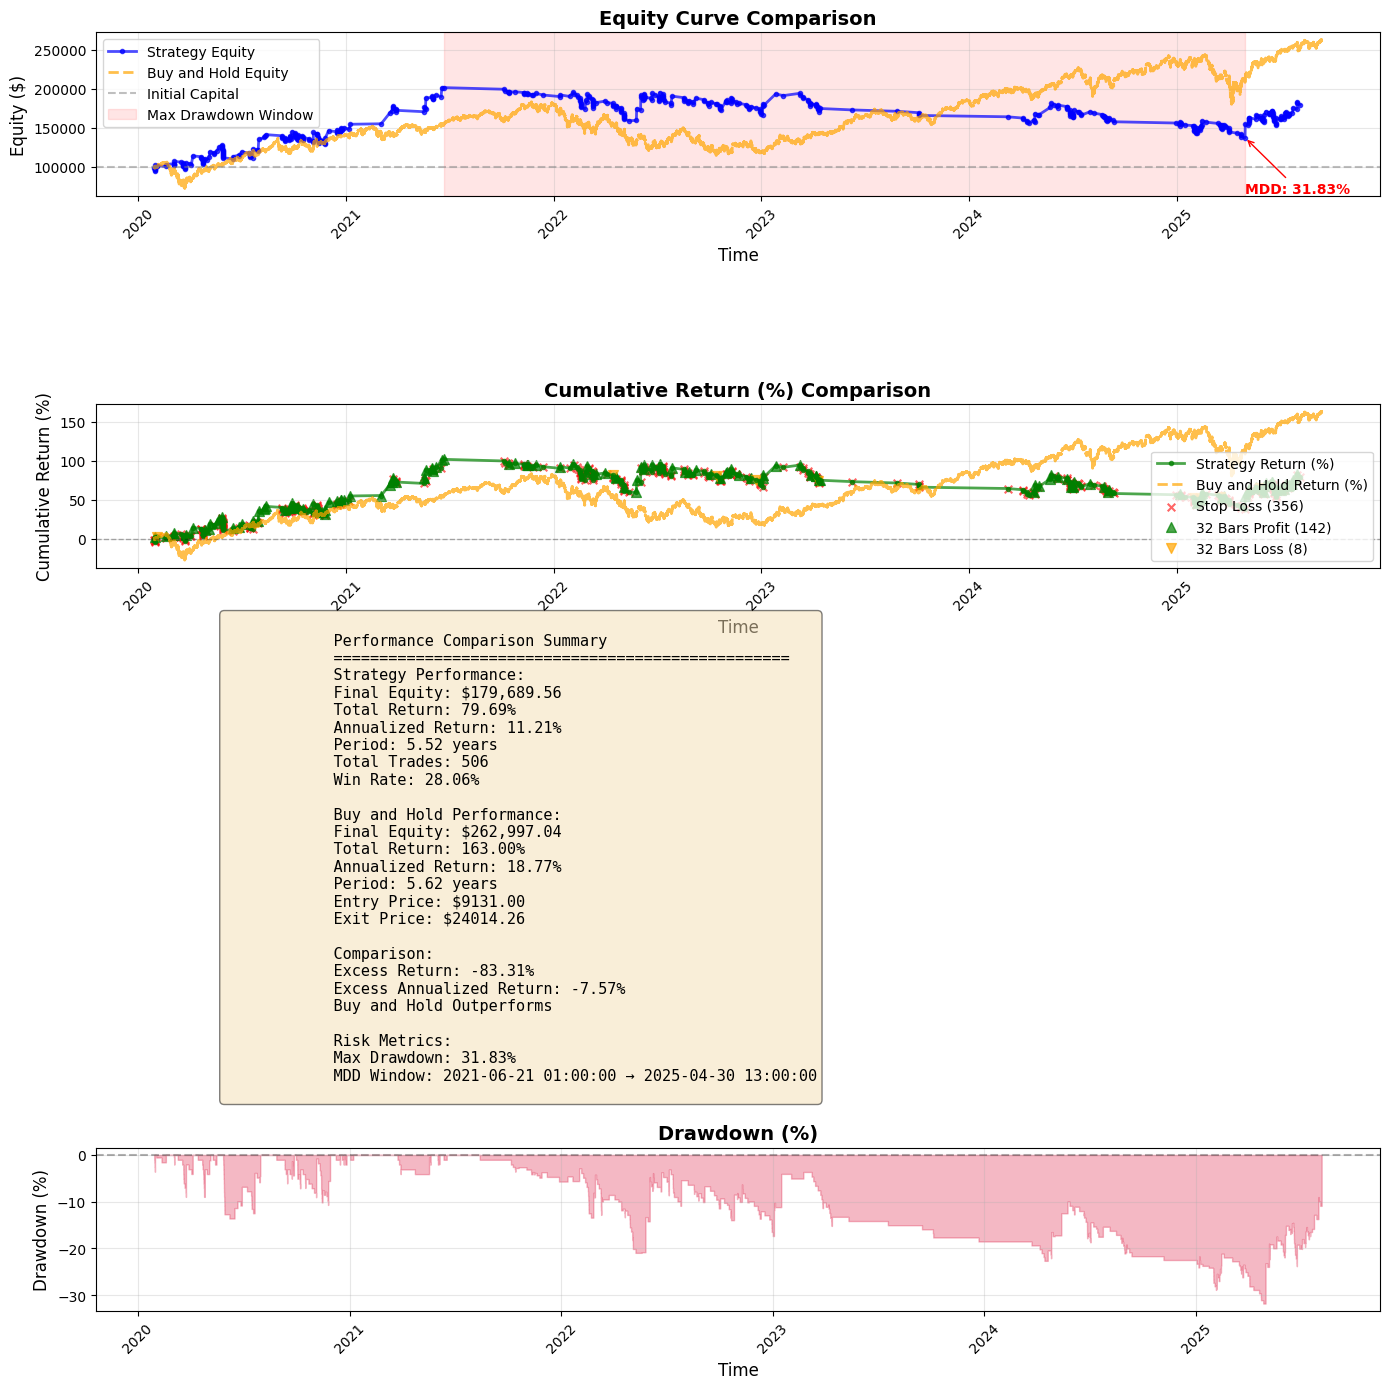


詳細績效指標:
Initial Capital: 100000
Final Equity: 179689.5627252994
Total PnL: 79689.5627252993
Total Return (%): 79.6895627252994
Total Trades: 506
Winning Trades: 142
Losing Trades: 364
Win Rate (%): 28.063241106719367
Average Return (%): 0.14192162018851748
Average Win (%): 3.0551097751016054
Average Loss (%): -0.9945418907940607
Average Win Amount: 4614.325086642177
Average Loss Amount: -1581.16648235684
Profit Factor: 1.1384594048554089
Stop Loss Count: 356
Take Profit Pct Count: 0
Take Profit Pct Win Count: 0
Take Profit Pct Loss Count: 0
Take Profit Bars Count: 150
Take Profit Bars Win Count: 142
Take Profit Bars Loss Count: 8
Leverage 0.5x Count: 0
Leverage 1.0x Count: 0
Leverage 2.0x Count: 31
📊 每月統計摘要
總月份數: 54
賺錢月份: 28 (51.85%)
虧錢月份: 26 (48.15%)

每月詳細統計:
------------------------------------------------------------
2020-01: Profit | PnL: $  2,223.76 | Trades:    6 | Win Rate:  16.67%
2020-02: Profit | PnL: $    868.55 | Trades:    4 | Win Rate:  25.00%
2020-03: Profit | PnL: $  1

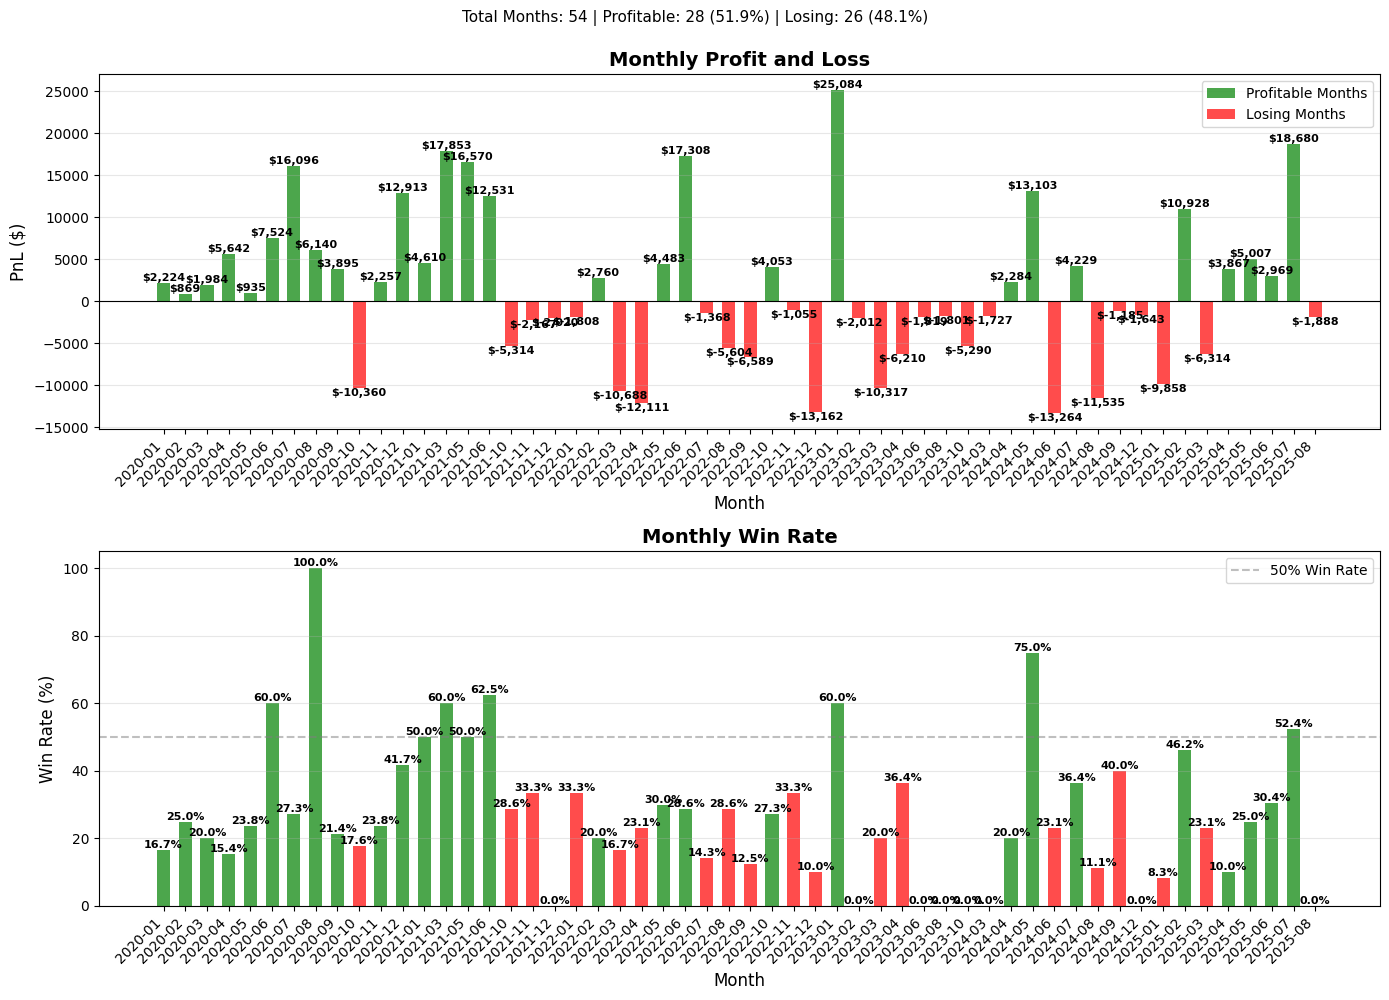

In [ ]:
# 使用範例
# 假設你已經載入 nas100_raw (含 Open/High/Low/Close)

# dt et lightgbm lr nb rf svm xgboost
ML_PRED_FILE = r'C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaMaCrossUp\pred_results\pred_xgboost_2020_2025.csv'                # 指定要使用的預測檔
ALLOWED_PRED_LABELS = { 1, 0}                # 只允許 predicted_label = 1 或 0 進場
# LEVERAGE_MAP = {-1: 1, 0: 1, 1: 1}    # 需要的槓桿對應
LEVERAGE_MAP = {-1: 1, 0: 2, 1: 4} 

# 1. 初始化策略（結合 L1 + ML）
strategy = MCrossUpLeverageStrategy(
    entry_param=480,
    # rolling_window=96,
    ml_pred_file=ML_PRED_FILE,
    allowed_predicted_labels=ALLOWED_PRED_LABELS,
    leverage_map=LEVERAGE_MAP
)
df_with_signals = strategy.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（例：0.25% 停損，32 根 K 停利）
backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_bars=32, take_profit_pct=0.0025)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal'],
    leverage_series=df_with_signals['leverage']  # 傳入 ML 調整後的槓桿
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.tail(10))

# 5. 查看績效摘要與圖表
backtest.print_summary()
backtest.plot_equity_curve()

# 6. 詳細指標與每月統計
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")

backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()

預測信心調整部位

In [ ]:
class MCrossUpLeverageStrategy:
    """MCrossUp 策略 + ML 預測篩選 + 槓桿調整 (含信心度)"""

    def __init__(
        self,
        entry_param: int = 20,
        rolling_window: int = 20,
        ml_pred_file: str = 'Pred_xgb.csv',
        allowed_predicted_labels: Optional[Iterable[int]] = None,
        leverage_map: Optional[Dict[int, float]] = None,
    ):
        self.entry_param = int(entry_param)
        self.ml_pred_file = ml_pred_file
        self.signals = None

        # 允許的 predicted_label；None 代表不過濾
        self.allowed_predicted_labels = (
            set(allowed_predicted_labels) if allowed_predicted_labels is not None else None
        )

        # 保留舊有映射 (可能仍需 fallback)
        self.leverage_map = leverage_map or {-1: 0.5, 0: 1.0, 1: 2.0}

        self.ml_predictions = None
        self.ml_predicted_labels = None
        self.ml_prediction_confidence = None
        self.ml_start_time = None

        self._load_ml_predictions()

    def _load_ml_predictions(self):
        """載入 ML 預測檔（須含 Date/entry_time、predicted_label、prediction_confidence 欄位）"""
        try:
            ml_df = pd.read_csv(self.ml_pred_file)

            # 優先使用 entry_time
            if 'entry_time' in ml_df.columns:
                date_col = 'entry_time'
            elif 'Date' in ml_df.columns:
                date_col = 'Date'
            else:
                date_col = ml_df.columns[0]
            
            ml_df[date_col] = pd.to_datetime(ml_df[date_col])
            ml_df.set_index(date_col, inplace=True)
            ml_df.sort_index(inplace=True)

            if 'predicted_label' not in ml_df.columns:
                raise ValueError(f"{self.ml_pred_file} 缺少 predicted_label 欄位")
            if 'prediction_confidence' not in ml_df.columns:
                raise ValueError(f"{self.ml_pred_file} 缺少 prediction_confidence 欄位")

            self.ml_predicted_labels = ml_df['predicted_label']
            self.ml_prediction_confidence = (
                ml_df['prediction_confidence']
                .astype(float)
                .clip(lower=0.0)
                .fillna(0.0)
            )

            # 根據 label + confidence 轉成槓桿
            leverage_series = pd.Series(1.0, index=ml_df.index, dtype=float)
            # leverage_series[self.ml_predicted_labels == -1] = 1.0
            # 修正版本 - 使用 clip 方法
            leverage_series[self.ml_predicted_labels == -1] = (
                1.0 - (self.ml_prediction_confidence * 1.0).clip(upper=0.66)
            )
            leverage_series[self.ml_predicted_labels == 1] = (
                1.0 + (self.ml_prediction_confidence * 4.0)  # 建議加上槓桿上限
            )
            
            self.ml_predictions = leverage_series
            self.ml_start_time = leverage_series.index[0]

            print(f"✅ 載入 {self.ml_pred_file}：{len(self.ml_predictions):,} 筆")
            print(f"   時間範圍：{self.ml_predictions.index[0]} ~ {self.ml_predictions.index[-1]}")
            print("   predicted_label 分布：")
            for label, count in self.ml_predicted_labels.value_counts().sort_index().items():
                print(f"     {label}: {count:,}")
        except Exception as e:
            print(f"⚠️ 載入 ML 預測失敗：{e}")
            self.ml_predictions = pd.Series(dtype=float)
            self.ml_predicted_labels = pd.Series(dtype=float)
            self.ml_prediction_confidence = pd.Series(dtype=float)
            self.ml_start_time = None

    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        # 移除時間裁切，避免影響 MA 計算
        # if self.ml_start_time is not None:
        #     df = df.loc[df.index >= self.ml_start_time].copy()

        # ---------------------------
        # 策略指標：MaCrossUp
        # ---------------------------
        ask_close = df['AskClose'] if 'AskClose' in df.columns else df['Close']
        ask_open = df['AskOpen'] if 'AskOpen' in df.columns else df['Open']
        ask_high = df['AskHigh'] if 'AskHigh' in df.columns else df['High']

        # 1. 計算 MA (shift(1) 避免未來視)
        df['MA'] = ask_close.shift(1).rolling(window=self.entry_param).mean()
        
        # 2. 生成穿越信號
        prev_close = ask_close.shift(1)
        
        df['signal'] = (
            (prev_close < df['MA']) &  # 前一根收盤在 MA 下
            (ask_high > df['MA']) &    # 當前最高價穿越 MA
            (ask_open < df['MA'])      # 當前開盤價在 MA 下
        )
        
        # 前 entry_param 根無信號
        df.loc[df.index[:self.entry_param], 'signal'] = False

        # ---------------------------
        # ML 預測與槓桿
        # ---------------------------
        df['leverage'] = 1.0
        df['predicted_label'] = np.nan

        if self.ml_predictions is not None and len(self.ml_predictions) > 0:
            aligned_labels = self.ml_predicted_labels.reindex(df.index, method='ffill')
            aligned_leverage = self.ml_predictions.reindex(df.index, method='ffill').fillna(1.0)

            df['predicted_label'] = aligned_labels
            df['leverage'] = aligned_leverage

            if self.ml_start_time is not None:
                analysis_mask = df.index >= self.ml_start_time
                signal_labels = df.loc[df['signal'] & analysis_mask, 'predicted_label'].dropna()
                matched = len(signal_labels)
                total_signals = int(df.loc[analysis_mask, 'signal'].sum())
                
                print(f"✅ MCrossUp 信號 {total_signals:,} 筆 (在 ML 範圍內)，成功匹配 {matched:,} 筆 ML 預測")
                if matched > 0:
                    for label, count in signal_labels.value_counts().sort_index().items():
                        lev_desc = "1 - conf" if label == -1 else ("1 + conf" if label == 1 else "1")
                        print(f"   predicted_label={label}: {count:,} (leverage rule: {lev_desc})")
        else:
            print("⚠️ 無 ML 槓桿資料，全部使用 1.0x")

        if self.allowed_predicted_labels is not None:
            allowed_mask = df['predicted_label'].isin(self.allowed_predicted_labels).fillna(False)
            
            if self.ml_start_time is not None:
                check_mask = (df.index >= self.ml_start_time) & df['signal']
                blocked = int(check_mask.sum() - (check_mask & allowed_mask).sum())
                print(f"🔍 ML 過濾：排除 {blocked:,} 筆不在 {sorted(self.allowed_predicted_labels)} 的信號")
            
            df['signal'] = df['signal'] & allowed_mask
            df.loc[~allowed_mask, 'leverage'] = 1.0

        df['side'] = np.nan
        df.loc[df['signal'], 'side'] = 1.0
        df['side'] = df['side'].ffill()

        self.signals = df

        signal_df = df[df['signal']]
        leverage_counts = signal_df['leverage'].round(4).value_counts().sort_index()

        print("=" * 60)
        print("📊 MCrossUp + ML 策略統計")
        print("=" * 60)
        print(f"總 K 線數: {len(df):,}")
        print(f"MCrossUp 信號數: {len(signal_df):,}")
        for lev, count in leverage_counts.items():
            print(f"  槓桿 {lev}x: {count:,} 筆")
        print("=" * 60)

        return df

    def get_signal_events(self) -> pd.DatetimeIndex:
        if self.signals is None:
            print("⚠️ 請先執行 calculate_indicators()")
            return None
        return self.signals.index[self.signals['signal']]

    def get_signal_stats(self) -> dict:
        if self.signals is None:
            return {}
        sig = self.signals[self.signals['signal']]
        total = len(sig)
        counts = sig['leverage'].value_counts().to_dict()
        return {
            'total_signals': total,
            'signal_rate': total / len(self.signals),
            'leverage_counts': counts,
            'avg_MA': self.signals['MA'].mean(),
            'avg_price_to_signal': (self.signals['Close'] / self.signals['MA']).mean(),
        }

✅ 載入 C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaMaCrossUp\pred_results\pred_xgboost_2020_2025.csv：1,124 筆
   時間範圍：2020-01-29 01:30:00 ~ 2025-08-06 15:00:00
   predicted_label 分布：
     -1: 467
     0: 35
     1: 622
✅ MCrossUp 信號 2,258 筆 (在 ML 範圍內)，成功匹配 2,258 筆 ML 預測
   predicted_label=-1.0: 1,229 (leverage rule: 1 - conf)
   predicted_label=0.0: 77 (leverage rule: 1)
   predicted_label=1.0: 952 (leverage rule: 1 + conf)
📊 MCrossUp + ML 策略統計
總 K 線數: 137,458
MCrossUp 信號數: 2,334
  槓桿 0.34x: 666 筆
  槓桿 0.3405x: 1 筆
  槓桿 0.3435x: 1 筆
  槓桿 0.3453x: 1 筆
  槓桿 0.3468x: 2 筆
  槓桿 0.3479x: 1 筆
  槓桿 0.3485x: 1 筆
  槓桿 0.3507x: 1 筆
  槓桿 0.3524x: 2 筆
  槓桿 0.3529x: 2 筆
  槓桿 0.3536x: 1 筆
  槓桿 0.3551x: 1 筆
  槓桿 0.3553x: 2 筆
  槓桿 0.3556x: 1 筆
  槓桿 0.3557x: 1 筆
  槓桿 0.3559x: 1 筆
  槓桿 0.358x: 1 筆
  槓桿 0.3587x: 1 筆
  槓桿 0.3607x: 1 筆
  槓桿 0.3653x: 1 筆
  槓桿 0.3662x: 1 筆
  槓桿 0.3708x: 1 筆
  槓桿 0.3748x: 1 筆
  槓桿 0.3749x: 1 筆
  槓桿 0.3755x: 2 筆
  槓桿 0.3759x: 1 筆
  槓桿 0.3761x: 1 筆
  槓桿 0.3767x: 1 筆
  槓桿 

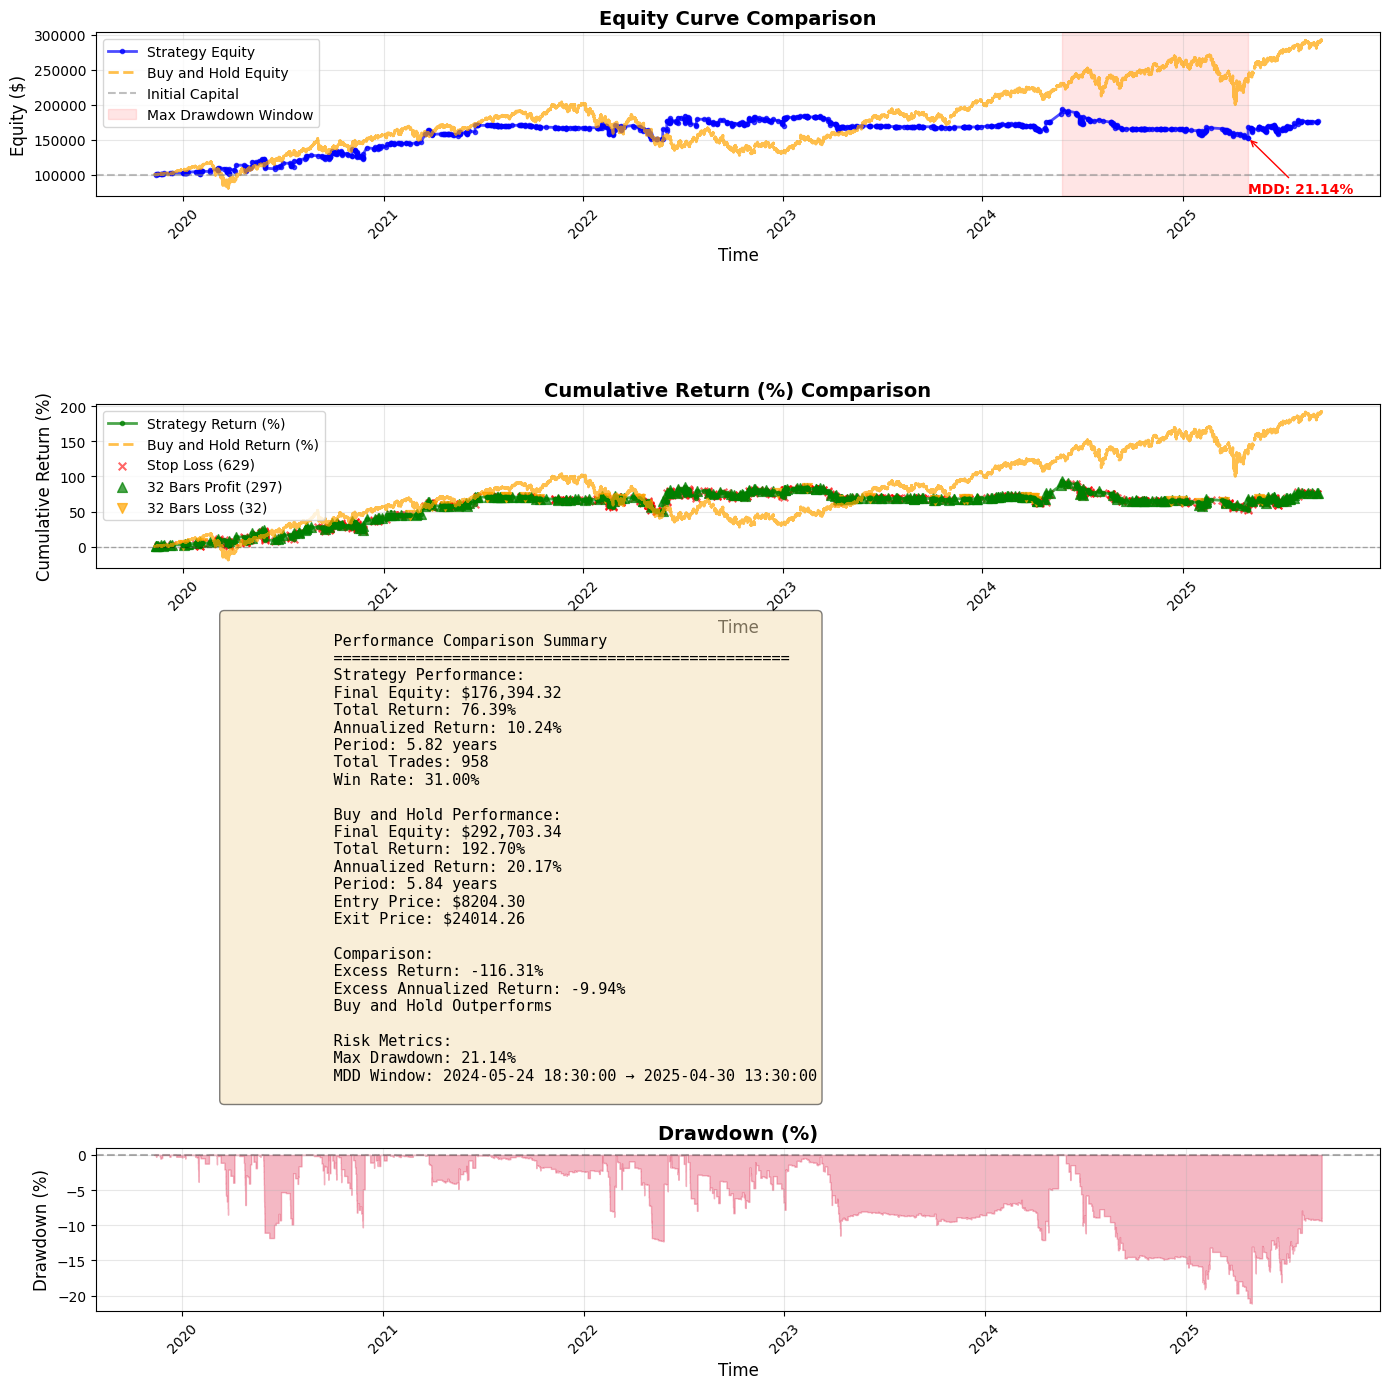


詳細績效指標:
Initial Capital: 100000
Final Equity: 176394.32450913225
Total PnL: 76394.32450913194
Total Return (%): 76.39432450913225
Total Trades: 958
Winning Trades: 297
Losing Trades: 661
Win Rate (%): 31.002087682672236
Average Return (%): 0.06847175862077283
Average Win (%): 1.266387030126087
Average Loss (%): -0.4697745887878177
Average Win Amount: 1884.2625005742832
Average Loss Amount: -731.0614798206204
Profit Factor: 1.1580904859619547
Stop Loss Count: 629
Take Profit Pct Count: 0
Take Profit Pct Win Count: 0
Take Profit Pct Loss Count: 0
Take Profit Bars Count: 329
Take Profit Bars Win Count: 297
Take Profit Bars Loss Count: 32
Leverage 0.5x Count: 0
Leverage 1.0x Count: 51
Leverage 2.0x Count: 0
📊 每月統計摘要
總月份數: 71
賺錢月份: 41 (57.75%)
虧錢月份: 30 (42.25%)

每月詳細統計:
------------------------------------------------------------
2019-11: Profit | PnL: $  1,992.28 | Trades:   10 | Win Rate:  70.00%
2019-12: Profit | PnL: $    328.31 | Trades:    5 | Win Rate:  40.00%
2020-01: Profit | PnL:

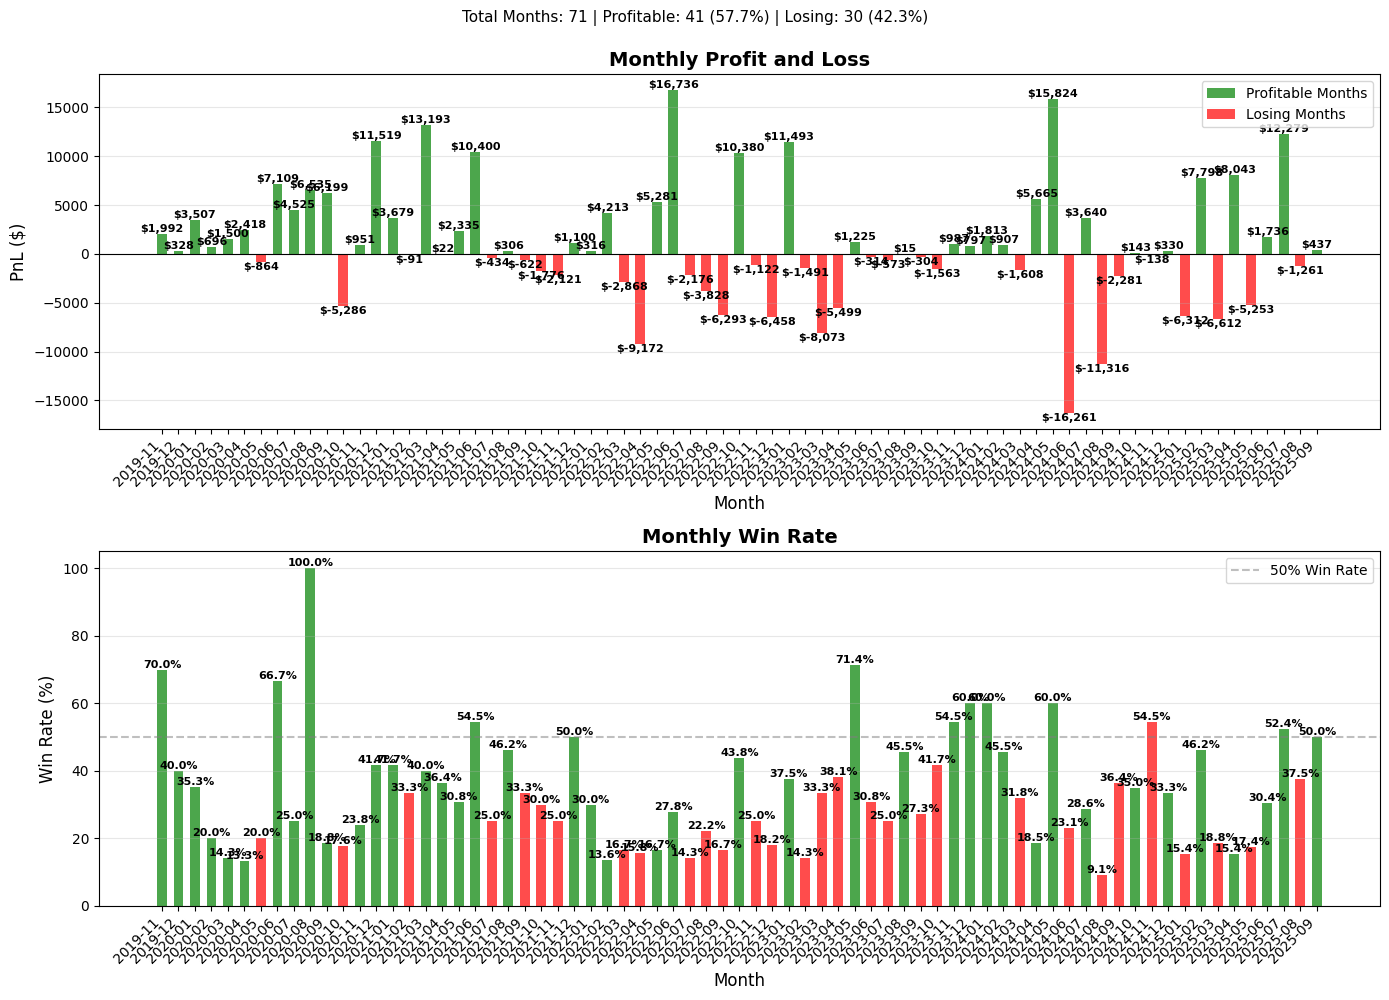

In [ ]:
# 使用範例
# 假設你已經載入 nas100_raw (含 Open/High/Low/Close)

# === 可調整參數 ===
ML_PRED_FILE = r'C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaMaCrossUp\pred_results\pred_xgboost_2020_2025.csv'                # 指定要使用的預測檔
ALLOWED_PRED_LABELS = {1, 0, -1}                # 只允許 predicted_label = 1 或 0 進場
# LEVERAGE_MAP = {-1: 1, 0: 1, 1: 1}    # 需要的槓桿對應
LEVERAGE_MAP = {-1: 0.5, 0: 1, 1: 2} 

# 1. 初始化策略（結合 L1 + ML）
strategy = MCrossUpLeverageStrategy(
    entry_param=480,
    # rolling_window=96,
    ml_pred_file=ML_PRED_FILE,
    allowed_predicted_labels=None,
)
df_with_signals = strategy.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（例：0.25% 停損，32 根 K 停利）
backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_bars=32, take_profit_pct=0.0025)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal'],
    leverage_series=df_with_signals['leverage']  # 傳入 ML 調整後的槓桿
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.head(10))

# 5. 查看績效摘要與圖表
backtest.print_summary()
backtest.plot_equity_curve()

# 6. 詳細指標與每月統計
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")

backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()